# Countries Categorisation 

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [114]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [216]:
# Random state seed
rseed = 42

## Data Loading and Exploration

In [217]:
# Import the dataset
df = pd.read_csv('Country-data.csv')

In [218]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [219]:
# Check the shape
df.shape

(167, 10)

In [220]:
# Check datatypes & counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [221]:
# Get descriptive statistics
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [222]:
# Identify any missing data
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## Preprocessing and Feature Selection

In [223]:
# Store the 'country' column in a separate variable
country_column = df['country']

In [224]:
# Drop any non-numeric features (columns)
df = df.select_dtypes(include=[np.number])

In [225]:
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Highly Correlated Features:
{'total_fer', 'child_mort', 'income', 'gdpp', 'life_expec'}


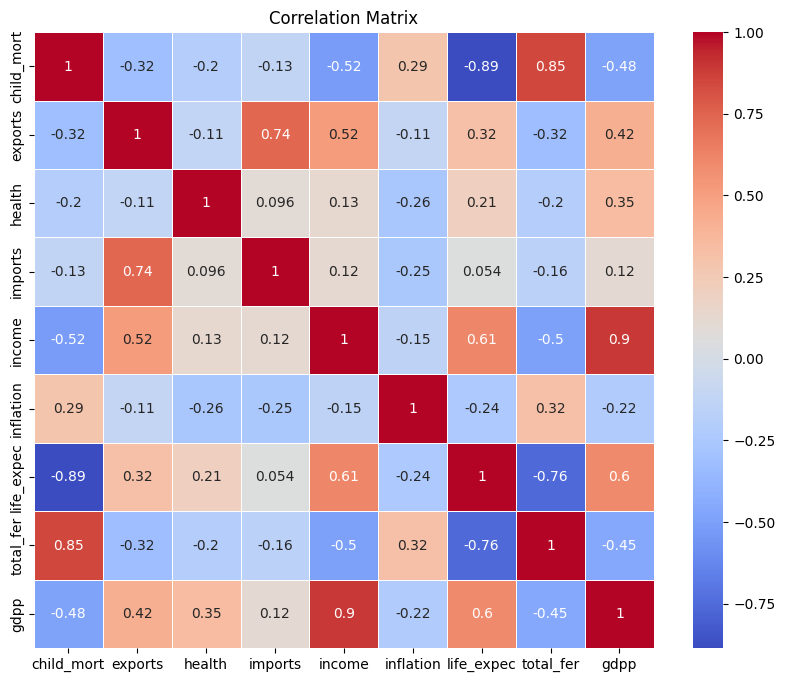

In [226]:
# Create a correlation map of features to explore relationships between features
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')

# Identify highly correlated features
high_corr_features = set()
corr_threshold = 0.8  # Adjust the threshold as per your requirement
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            high_corr_features.add(corr_matrix.columns[i])
            high_corr_features.add(corr_matrix.columns[j])

print("Highly Correlated Features:")
print(high_corr_features)

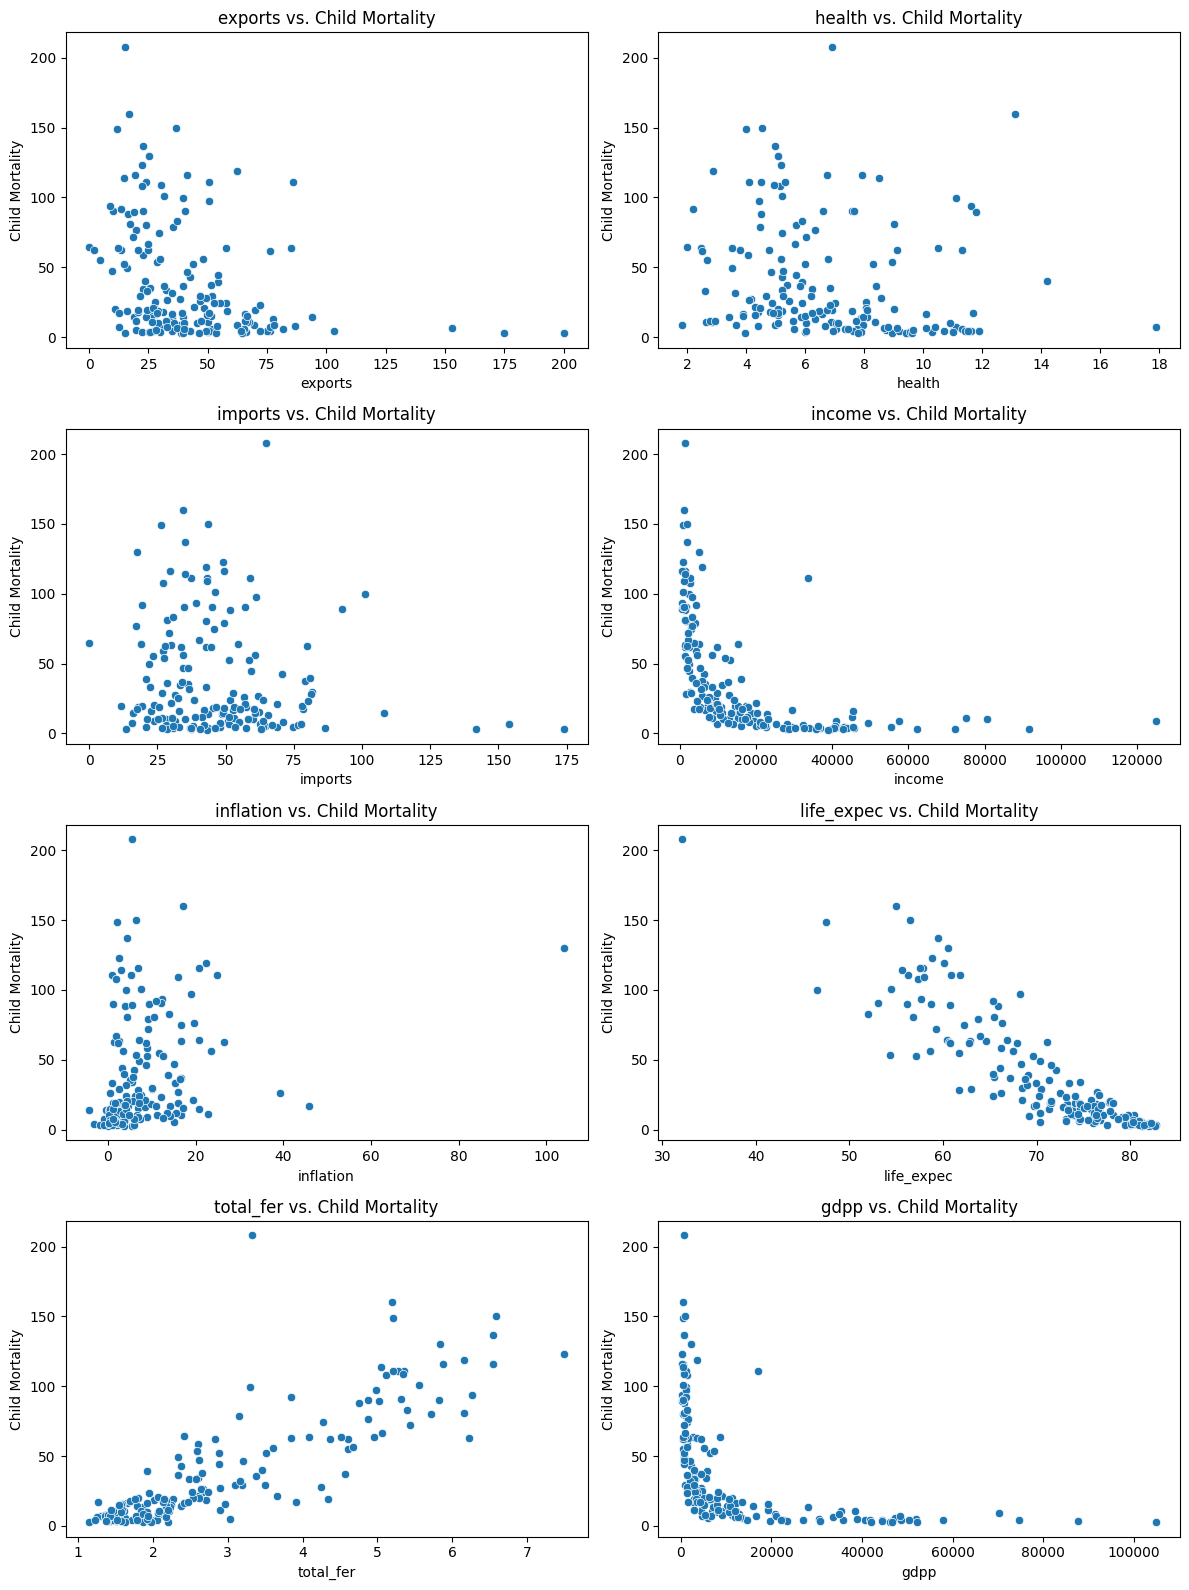

In [227]:
# Explore the continuous independent features against child_mort using scatter plots.
cols = ['exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
n_cols = 2
n_rows = len(cols) // n_cols + (len(cols) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.scatterplot(x=col, y='child_mort', data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs. Child Mortality')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Child Mortality')

plt.tight_layout()

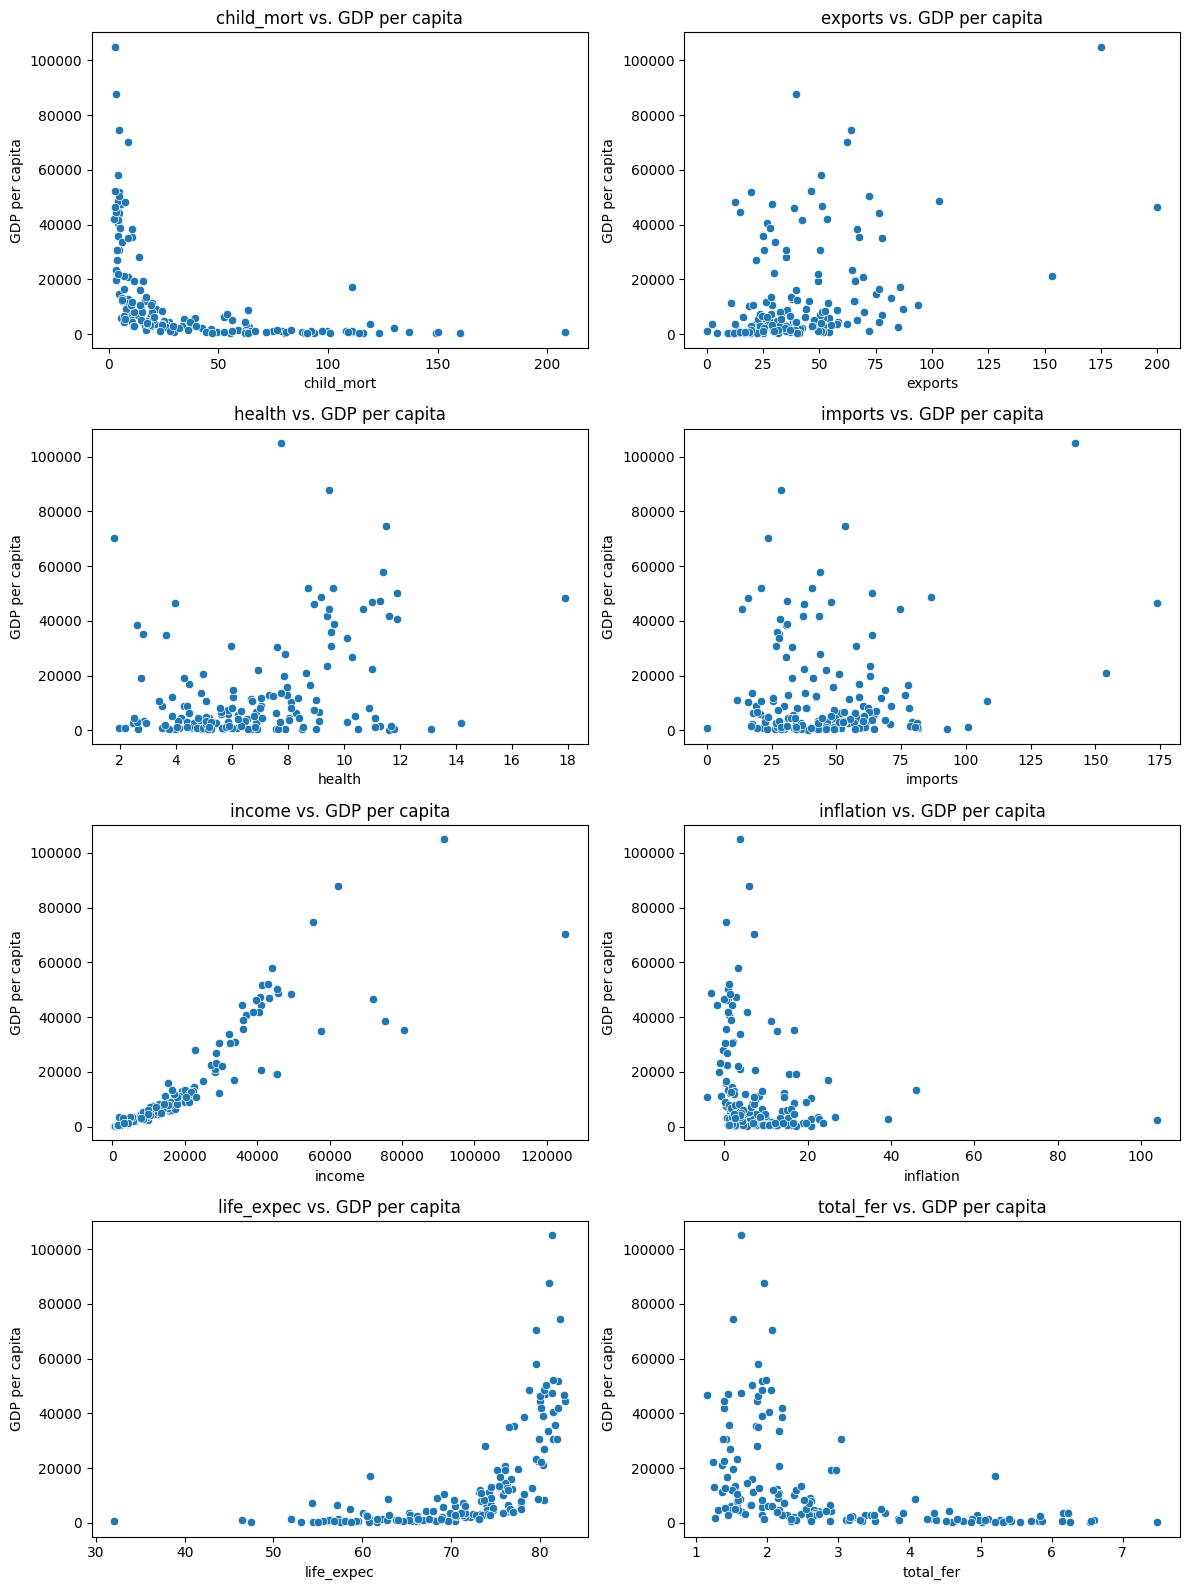

In [228]:
# Explore the continuous independent features against gdpp using scatter plots.
cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer']
n_cols = 2
n_rows = len(cols) // n_cols + (len(cols) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.scatterplot(x=col, y='gdpp', data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs. GDP per capita')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('GDP per capita')

plt.tight_layout()

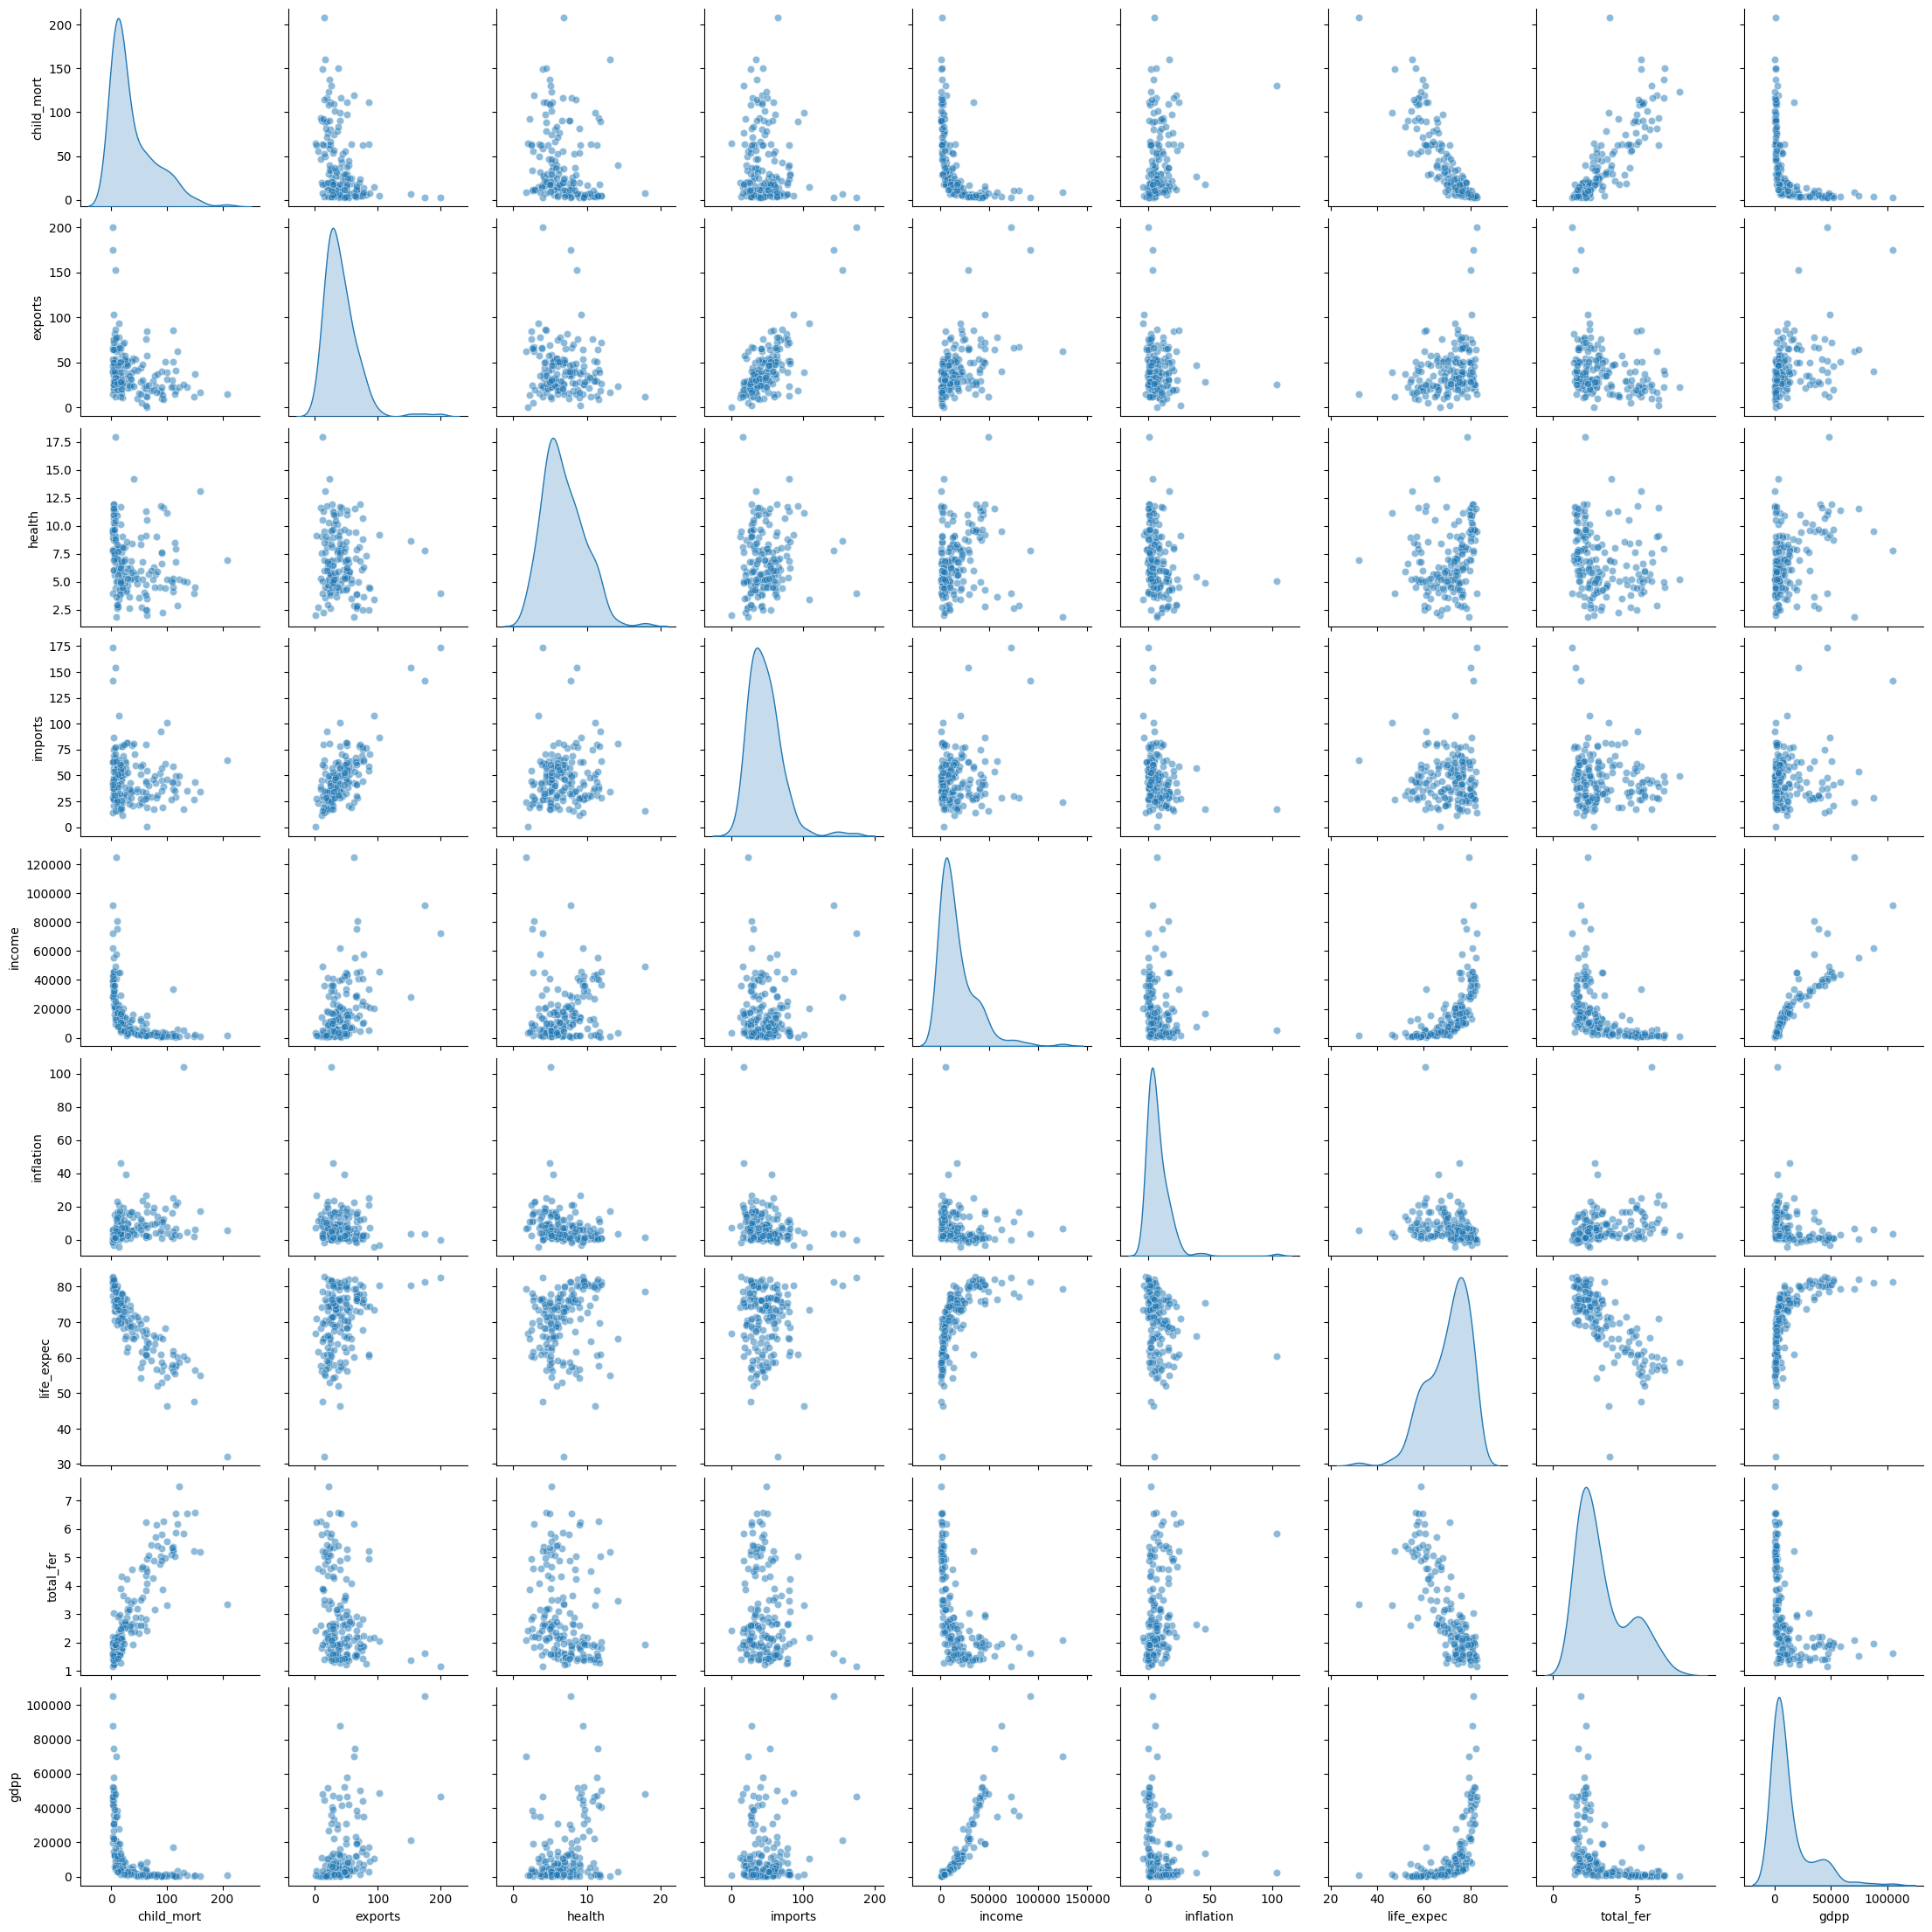

In [229]:
# Create a pair plot
cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

sns.pairplot(df[cols], diag_kind='kde', plot_kws={'alpha': 0.5})

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

In [230]:
# Drop the specified columns
columns_to_drop = ['life_expec','total_fer', 'exports', 'imports']
df = df.drop(columns=columns_to_drop)   # columns_to_drop = ['life_expec', 'income', 'total_fer', 'exports', 'imports']

### Data Scaling

In [231]:
# Normalise the data using MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [232]:
df_scaled.head()

,child_mort,health,income,inflation,gdpp
0,0.426485,0.358608,0.008047,0.126144,0.003073
1,0.068160,0.294593,0.074933,0.080399,0.036833
2,0.120253,0.146675,0.098809,0.187691,0.040365
3,0.566699,0.064636,0.042535,0.245911,0.031488
4,0.037488,0.262275,0.148652,0.052213,0.114242


## K-Means Clustering

### Selecting K

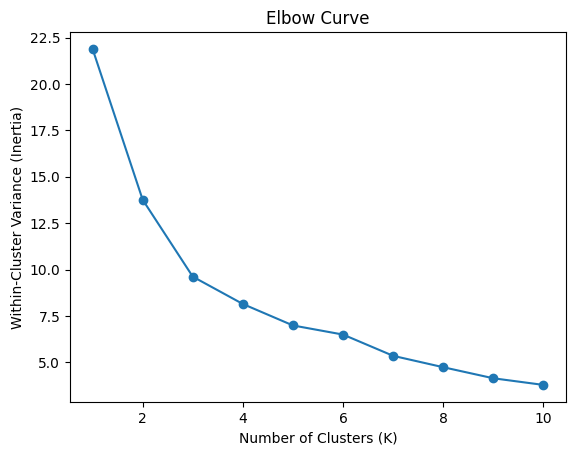

In [233]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Within-Cluster Variance (Inertia)')
    plt.title('Elbow Curve')

# Plot elbow curve using scaled dataset
elbow_Kmeans(df_scaled)

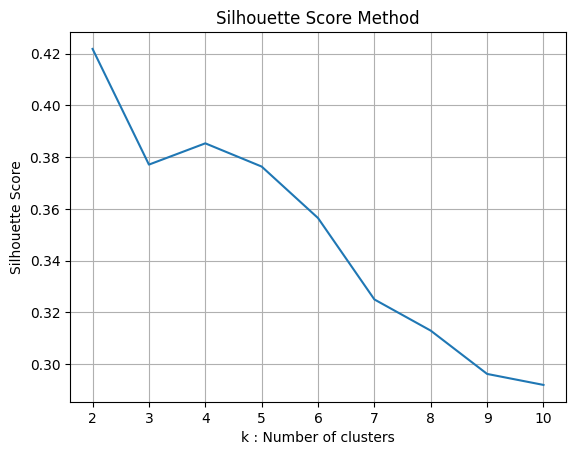

In [234]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)

Based on the elbow and silhouette score method choose a value for K.

## Fitting a K-Means Model with the Selected K Value

In [239]:
# Optimal number of clusters
optimal_k = 2

In [240]:
# Fit the scaled dataset to the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=rseed, max_iter=500)
kmeans.fit(df_scaled)

KMeans(max_iter=500, n_clusters=2, random_state=42)

In [241]:
# Count the number of records in each cluster
print(pd.Series(kmeans.labels_).value_counts())

0    129
1     38
Name: count, dtype: int64


In [242]:
# Check model performance with the silhouette coefficient
print("Silhouette Coefficient:", silhouette_score(df_scaled, kmeans.labels_)) 

Silhouette Coefficient: 0.42181707950109065


In [243]:
# Create a new DataFrame with the country names and cluster labels
df_clusters = pd.DataFrame({'Country': country_column, 'Cluster': kmeans.labels_})

In [244]:
# Merge the new DataFrame with the modified original DataFrame
df_merged = pd.concat([df, df_clusters], axis=1)

# Display the merged DataFrame
print(df_merged)

     child_mort  health  income  inflation   gdpp              Country  \
0          90.2    7.58    1610       9.44    553          Afghanistan   
1          16.6    6.55    9930       4.49   4090              Albania   
2          27.3    4.17   12900      16.10   4460              Algeria   
3         119.0    2.85    5900      22.40   3530               Angola   
4          10.3    6.03   19100       1.44  12200  Antigua and Barbuda   
..          ...     ...     ...        ...    ...                  ...   
162        29.2    5.25    2950       2.62   2970              Vanuatu   
163        17.1    4.91   16500      45.90  13500            Venezuela   
164        23.3    6.84    4490      12.10   1310              Vietnam   
165        56.3    5.18    4480      23.60   1310                Yemen   
166        83.1    5.89    3280      14.00   1460               Zambia   

     Cluster  
0          0  
1          0  
2          0  
3          0  
4          0  
..       ...  
162   

## Cluster Visualisations

Text(0, 0.5, 'GDP per capita')

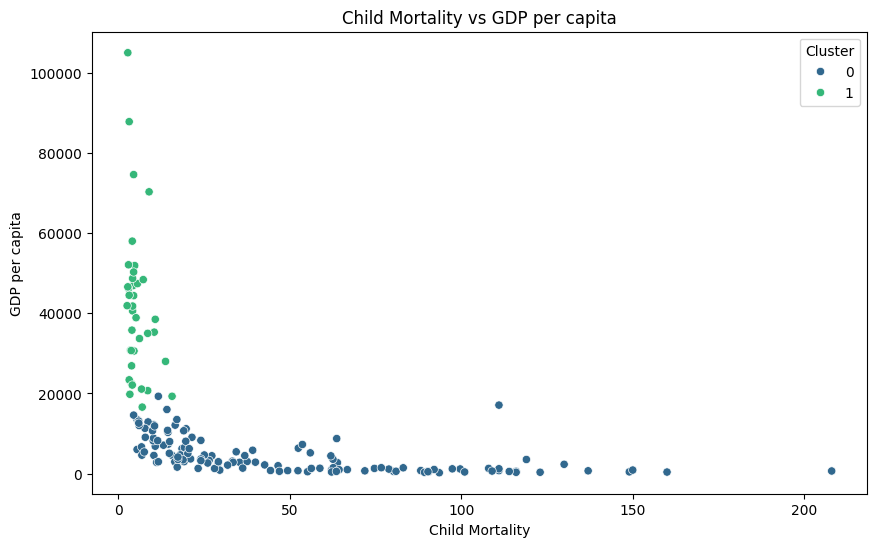

In [245]:
# Visualisation of clusters: child mortality vs gdpp
plt.figure(figsize=(10, 6))
sns.scatterplot(x='child_mort', y='gdpp', hue='Cluster', data=df_merged, palette='viridis')
plt.title('Child Mortality vs GDP per capita')
plt.xlabel('Child Mortality')
plt.ylabel('GDP per capita')

Text(0, 0.5, 'GDP per capita')

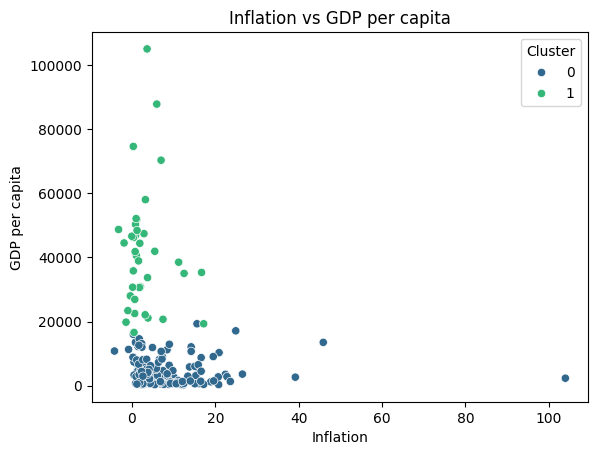

In [246]:
# Visualisation of clusters: inflation vs gdpp
sns.scatterplot(x='inflation', y='gdpp', hue='Cluster', data=df_merged, palette='viridis')
plt.title('Inflation vs GDP per capita')
plt.xlabel('Inflation')
plt.ylabel('GDP per capita')

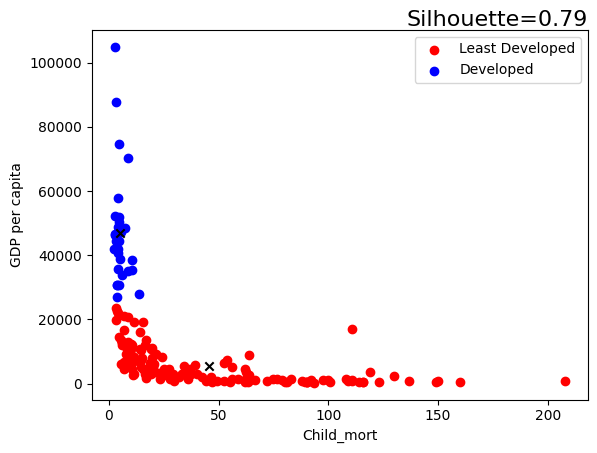

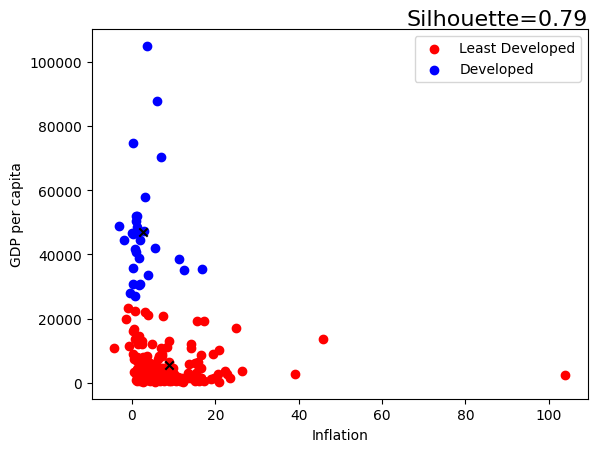

In [249]:
# Label the cluster groups
def scatter_Kmeans(x, y, k, r=123):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(x)

    colours = 'rb'
    labels = ['Least Developed', 'Developed']

    for c in range(k):
        cluster_data = x[y_pred == c]
        cluster_label = labels[c]

        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=colours[c], label=cluster_label)
        plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c='black')

    score = round(silhouette_score(x, kmeans.labels_, metric='euclidean'), 2)
    plt.title('Silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel(y.name.capitalize())
    plt.ylabel('GDP per capita')
    plt.legend()
    plt.show()

# Visualisation of clusters: child mortality vs gdpp
scatter_Kmeans(df[['child_mort', 'gdpp']].values, df['child_mort'], optimal_k)

# Visualisation of clusters: inflation vs gdpp
scatter_Kmeans(df[['inflation', 'gdpp']].values, df['inflation'], optimal_k)

## Conclusion

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer:**

1. Child Mortality vs GDP per Capita
- "Least Developed": The cluster with higher child mortality rates and lower GDP per capita. These countries are likely to have poor healthcare systems, leading to higher child mortality, and lower economic development, reflected by lower GDP per capita.
- "Developed": The cluster with lower child mortality rates and higher GDP per capita. These countries are likely to have better healthcare systems, resulting in lower child mortality, and higher economic development, indicated by higher GDP per capita.

2. Inflation vs GDP per Capita
- "Least Developed": The cluster with higher inflation rates and lower GDP per capita. These countries may have unstable economies, leading to high inflation, and lower economic development, reflected by lower GDP per capita.
- "Developed": The cluster with lower inflation rates and higher GDP per capita. These countries are likely to have more stable economies, maintaining lower inflation rates, and higher economic development, indicated by higher GDP per capita.